# Disseration Experiment 6j
# Generate DICE Output (Credit Card Fraud) - Experiment Jan 19¶
Ciaran Finnegan January 2024

# Import Libraries + Custom Functions

## Import Libraries

In [1]:
# Import libs
import numpy as np
import pandas as pd

# Display libraries
from IPython.display import display, HTML
from prettytable import PrettyTable
import raiutils
from raiutils.exceptions import UserConfigValidationException


# Import necessary libraries for DICE explainer
import dice_ml
from dice_ml.utils import helpers  # helper functions


# Import necessary libraries for NN Modelling
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers


# Libraries required for metrics calculations
from scipy.spatial import distance
from sklearn.cluster import KMeans


# Libraries for Supplementary Model Evaluation
import sklearn.metrics
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score
from sklearn.metrics import roc_auc_score
from sklearn.utils import resample


# Classifier training (not used for explainability)
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV

# Libraries used in Experiment Creation of XL Output Metrics
import os
import time
import random
import openpyxl

2024-01-19 20:46:34.997341: I tensorflow/core/util/port.cc:110] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-01-19 20:46:35.000015: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2024-01-19 20:46:35.048360: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2024-01-19 20:46:35.049984: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX512F AVX512_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-01-19 20:46:35.905927: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Co

## Custom Functions

Dataset Visualisations

In [2]:
%run ./DS_Visualisation_Functions.ipynb

Metrics

In [3]:
%run ./XAI_Metrics_Functions.ipynb

Function 'example_function' executed in 2.0022 seconds
Result: Result, Execution Time: 2.002159357070923 seconds


Model Evaluation Functions

In [4]:
%run ./DS_Model_Build_Evaluation_Functions.ipynb

Track Experiment Result Functions

In [5]:
%run ./XAI_Experiment_Functions.ipynb

# Load Model

A Neural Network Model has been created in another Kubeflow Notebook and is being used in all the XAI experiments

In [6]:
loaded_model = keras.models.load_model('ccfraud_model')  # If saved as SavedModel

In [7]:
X_test_loaded, y_test_loaded, X_train_loaded, y_train_loaded, df_downsampled_loaded, dfCatCols = load_CC_train_test_data()

In [8]:
X_train_loaded.head(1)

,OnlinePOSCount.cnt.day.present,EMVTransactionsCount.cnt.day.present,NonEMVTransactionsCount.cnt.day.present,MerchantCategory,POS_Count.cnt.day.present,PinIndicator,DomesticAuthCount.cnt.hour1,DomesticAuthCount.cnt.hour3,DomesticAuthCount.cnt.hour4,DomesticAuthCount.cnt.hour10,...,TxnChannelCode_OnL,TxnChannelCode_POS,CustomerPresentIndicator_N,CustomerPresentIndicator_U,CustomerPresentIndicator_Y,DvcPosEntryMode_Card_Present,DvcPosEntryMode_E_Commerce,DvcPosEntryMode_U,ECommerceFlag_U,ECommerceFlag_Y
0,2,2,0,5462,2,1,1,1,1,2,...,0,1,0,0,1,1,0,0,1,0


In [9]:
y_train_loaded.head(2)

,Fraud
0,0
1,1


## Re-Display Model Peformance

For illustration, the evualtion metrics of the NN model will be repeated here.

### Tabular Data

In [10]:
scaler = StandardScaler()   
X_test_loaded_scaled = scaler.fit_transform(X_test_loaded)
X_train_loaded_scaled = scaler.fit_transform(X_train_loaded)
df_downsampled_loaded_scaled = scaler.fit_transform(df_downsampled_loaded)

In [11]:
y_pred_loaded = display_model_metrics_tabular(loaded_model, X_test_loaded_scaled, y_test_loaded)

42/42 [==============================] - 0s 1ms/step - loss: 0.6533 - accuracy: 0.8661


42/42 [==============================] - 0s 935us/step


Metric,Value
Accuracy,0.866058
ROC AUC Score,0.932477
Precision (Class 0),0.868580
Recall (Class 0),0.865964
F1-Score (Class 0),0.867270
Precision (Class 1),0.863497
Recall (Class 1),0.866154
F1-Score (Class 1),0.864823


Tablular Done!


### Confusion Matrix

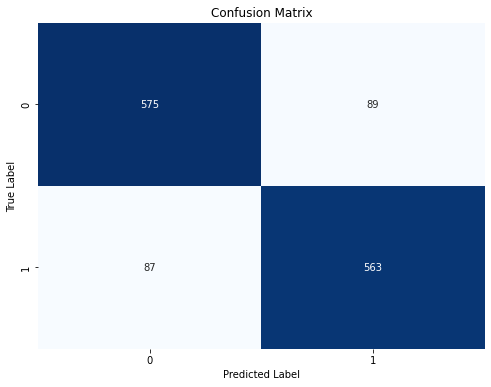

'Confusion Matrix!'

In [12]:
generate_confusion_matrix(y_test_loaded, y_pred_loaded)

# Generate DiCE Values (Examples Instances)

## Generate the Counterfactuals

In [13]:
#lCC_catcols_as_list = dfCatCols[dfCatCols.columns[0]].tolist()

### Use Tensor Flow - Prepare DiCE parameters - CC Dataset

#### Read External File Containing list of Continous Features

An analysis, external to this Notebook, has taken place to identify the set of continous features that will be use din this experiment to generate Counterfactual values.

In [14]:
# Read in file with list of continuous features for which to generate the DiCE Counterfactuals
def read_cc_features(file_path):
    # Read the CSV file
    data = pd.read_csv(file_path)

    # Filter the data where Rank is 39 or between 41 and 53 (inclusive)
    filtered_data = data[(data['RANK'] == 39) | ((data['RANK'] >= 41) & (data['RANK'] <= 55))]

    # Extract the 'Feature' column values and return them as a list
    feature_list = filtered_data['FEATURE'].tolist()
    return feature_list

In [15]:
# Assume the file is in the same directory as Notebook
file_path = 'Select_CC_Fraud_Features_v1_1.csv'
cc_continuous_features_list = read_cc_features(file_path)

In [16]:
# Display List of continous features loaded from external XL file.
cc_continuous_features_list

['AmountBase',
 'POSSum.acc.month.total',
 'NotECommerceAuthAmount.acc.day.total',
 'NonEMVTransactionsAcc.acc.day.total',
 'POSTerminalAttendedAuthAmount.acc.day.total',
 'CustomerPresentAuthAmount.acc.day.total',
 'EMVTransactionsAcc.acc.day.total',
 'CustomerNotPresentAuthAmount.acc.day.total',
 'HourlyAuthAmt.acc.hour25',
 'NonEMVTransactionsAcc.acc.day.present',
 'NotECommerceAuthAmount.acc.day.present',
 'CustomerNotPresentAuthAmount.acc.day.present',
 'POSTerminalAttendedAuthAmount.acc.day.present',
 'CustomerPresentAuthAmount.acc.day.present',
 'HighRiskPOSSum.acc.hour.total',
 'EMVTransactionsAcc.acc.day.present']

#### Build DiCE Counterfactual Function

In [17]:
df_downsampled_loaded_scaled

array([[ 0.02964117, -0.51313532, -0.30488937, ..., -0.47127297,
         0.82741488, -0.82741488],
       [ 0.02964117, -0.51313532,  0.00861296, ..., -0.47127297,
        -1.20858353,  1.20858353],
       [ 0.02964117, -0.51313532,  0.00861296, ..., -0.47127297,
         0.82741488, -0.82741488],
       ...,
       [ 0.32117186,  0.63239613, -0.46164054, ...,  2.12191248,
         0.82741488, -0.82741488],
       [ 0.32117186, -0.51313532, -0.30488937, ..., -0.47127297,
         0.82741488, -0.82741488],
       [ 0.02964117, -0.51313532, -0.30488937, ..., -0.47127297,
        -1.20858353,  1.20858353]])

In [18]:
df_downsampled_loaded

,OnlinePOSCount.cnt.day.present,EMVTransactionsCount.cnt.day.present,NonEMVTransactionsCount.cnt.day.present,MerchantCategory,POS_Count.cnt.day.present,PinIndicator,DomesticAuthCount.cnt.hour1,DomesticAuthCount.cnt.hour3,DomesticAuthCount.cnt.hour4,DomesticAuthCount.cnt.hour10,...,TxnChannelCode_OnL,TxnChannelCode_POS,CustomerPresentIndicator_N,CustomerPresentIndicator_U,CustomerPresentIndicator_Y,DvcPosEntryMode_Card_Present,DvcPosEntryMode_E_Commerce,DvcPosEntryMode_U,ECommerceFlag_U,ECommerceFlag_Y
0,-1,0,1,5631,0,0,1,1,1,1,...,1,0,0,0,1,1,0,0,1,0
1,-1,0,3,5499,1,0,0,0,1,1,...,1,0,1,0,0,0,1,0,0,1
2,-1,0,3,5943,1,0,1,1,1,1,...,0,1,0,0,1,1,0,0,1,0
3,-2,0,2,5499,0,0,0,0,0,0,...,1,0,1,0,0,0,1,0,0,1
4,-1,0,1,7011,0,0,1,1,1,1,...,1,0,0,1,0,1,0,0,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6565,-1,0,1,5968,0,0,0,0,0,0,...,1,0,1,0,0,1,0,0,1,0
6566,-13,0,13,7311,0,0,0,0,0,0,...,1,0,1,0,0,0,1,0,0,1
6567,1,1,0,8099,1,1,1,1,1,1,...,0,1,0,0,1,0,0,1,1,0
6568,1,0,1,5812,1,0,1,1,1,1,...,0,1,0,0,1,1,0,0,1,0


In [19]:
# Get the list of columns from loaded dataframe
original_cols_names = df_downsampled_loaded.columns.tolist()

In [20]:
# Convert NumPy array to DataFrame
df_downsampled_loaded_scaled = pd.DataFrame(df_downsampled_loaded_scaled, columns=original_cols_names)

In [21]:
df_downsampled_loaded_scaled

,OnlinePOSCount.cnt.day.present,EMVTransactionsCount.cnt.day.present,NonEMVTransactionsCount.cnt.day.present,MerchantCategory,POS_Count.cnt.day.present,PinIndicator,DomesticAuthCount.cnt.hour1,DomesticAuthCount.cnt.hour3,DomesticAuthCount.cnt.hour4,DomesticAuthCount.cnt.hour10,...,TxnChannelCode_OnL,TxnChannelCode_POS,CustomerPresentIndicator_N,CustomerPresentIndicator_U,CustomerPresentIndicator_Y,DvcPosEntryMode_Card_Present,DvcPosEntryMode_E_Commerce,DvcPosEntryMode_U,ECommerceFlag_U,ECommerceFlag_Y
0,0.029641,-0.513135,-0.304889,-0.317687,-0.520858,-0.551208,-0.098000,-0.185115,-0.211268,-0.282796,...,0.867179,-0.867179,-0.890025,-0.408864,1.187859,1.230199,-0.851654,-0.471273,0.827415,-0.827415
1,0.029641,-0.513135,0.008613,-0.444830,-0.045113,-0.551208,-0.772195,-0.704196,-0.211268,-0.282796,...,0.867179,-0.867179,1.123564,-0.408864,-0.841851,-0.812877,1.174185,-0.471273,-1.208584,1.208584
2,0.029641,-0.513135,0.008613,-0.017166,-0.045113,-0.551208,-0.098000,-0.185115,-0.211268,-0.282796,...,-1.153164,1.153164,-0.890025,-0.408864,1.187859,1.230199,-0.851654,-0.471273,0.827415,-0.827415
3,-0.116124,-0.513135,-0.148138,-0.444830,-0.520858,-0.551208,-0.772195,-0.704196,-0.703303,-0.697986,...,0.867179,-0.867179,1.123564,-0.408864,-0.841851,-0.812877,1.174185,-0.471273,-1.208584,1.208584
4,0.029641,-0.513135,-0.304889,1.011542,-0.520858,-0.551208,-0.098000,-0.185115,-0.211268,-0.282796,...,0.867179,-0.867179,-0.890025,2.445799,-0.841851,1.230199,-0.851654,-0.471273,0.827415,-0.827415
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6565,0.029641,-0.513135,-0.304889,0.006915,-0.520858,-0.551208,-0.772195,-0.704196,-0.703303,-0.697986,...,0.867179,-0.867179,1.123564,-0.408864,-0.841851,1.230199,-0.851654,-0.471273,0.827415,-0.827415
6566,-1.719543,-0.513135,1.576125,1.300505,-0.520858,-0.551208,-0.772195,-0.704196,-0.703303,-0.697986,...,0.867179,-0.867179,1.123564,-0.408864,-0.841851,-0.812877,1.174185,-0.471273,-1.208584,1.208584
6567,0.321172,0.632396,-0.461641,2.059514,-0.045113,1.814198,-0.098000,-0.185115,-0.211268,-0.282796,...,-1.153164,1.153164,-0.890025,-0.408864,1.187859,-0.812877,-0.851654,2.121912,0.827415,-0.827415
6568,0.321172,-0.513135,-0.304889,-0.143346,-0.045113,-0.551208,-0.098000,-0.185115,-0.211268,-0.282796,...,-1.153164,1.153164,-0.890025,-0.408864,1.187859,1.230199,-0.851654,-0.471273,0.827415,-0.827415


In [22]:
# Define the data for DiCE based on your DataFrame
#d = dice_ml.Data(dataframe=df_downsampled_loaded, continuous_features=cc_continuous_features_list, outcome_name='Fraud')

In [23]:
# Jan 18th - use new loaded model and data - SCALED
# Define the data for DiCE based on your DataFrame
d = dice_ml.Data(dataframe=df_downsampled_loaded_scaled, 
                 continuous_features=cc_continuous_features_list, 
                 outcome_name='Fraud')

In [24]:
# Use the backend as TensorFlow and link the model
m = dice_ml.Model(model=loaded_model, backend='TF2')

In [25]:
# Initialize DiCE
exp = dice_ml.Dice(d, m)

#### Example 1: Sample DiCE Counterfactual example (x2)

The code below provides examples of generated counterfactuals. In the first two examples, for each instance entry the code has generated five counterfactuals.

In [26]:
# Jan 18th - use new loaded model and data - SCALED
query_instances = df_downsampled_loaded_scaled.iloc[0:2].drop('Fraud', axis=1)  # Taking the first two instances

In [27]:
# Generate counterfactual explanations
# Change query instances to match the instances you are interested in
#query_instances = df_downsampled_loaded.iloc[0:2].drop('Fraud', axis=1)  # Taking the first two instances
counterfactuals = exp.generate_counterfactuals(query_instances, total_CFs=5, desired_class="opposite")

100%|██████████| 2/2 [00:02<00:00,  1.29s/it]


In [28]:
# Visualize the counterfactual explanations
counterfactuals.visualize_as_dataframe(show_only_changes=True)

Query instance (original outcome : 0)


,OnlinePOSCount.cnt.day.present,EMVTransactionsCount.cnt.day.present,NonEMVTransactionsCount.cnt.day.present,MerchantCategory,POS_Count.cnt.day.present,PinIndicator,DomesticAuthCount.cnt.hour1,DomesticAuthCount.cnt.hour3,DomesticAuthCount.cnt.hour4,DomesticAuthCount.cnt.hour10,...,TxnChannelCode_POS,CustomerPresentIndicator_N,CustomerPresentIndicator_U,CustomerPresentIndicator_Y,DvcPosEntryMode_Card_Present,DvcPosEntryMode_E_Commerce,DvcPosEntryMode_U,ECommerceFlag_U,ECommerceFlag_Y,Fraud
0,0.029641,-0.513135,-0.304889,-0.317687,-0.520858,-0.551208,-0.098,-0.185115,-0.211268,-0.282796,...,-0.867179,-0.890025,-0.408864,1.187859,1.230199,-0.851654,-0.471273,0.827415,-0.827415,0



Diverse Counterfactual set (new outcome: 1)


,OnlinePOSCount.cnt.day.present,EMVTransactionsCount.cnt.day.present,NonEMVTransactionsCount.cnt.day.present,MerchantCategory,POS_Count.cnt.day.present,PinIndicator,DomesticAuthCount.cnt.hour1,DomesticAuthCount.cnt.hour3,DomesticAuthCount.cnt.hour4,DomesticAuthCount.cnt.hour10,...,TxnChannelCode_POS,CustomerPresentIndicator_N,CustomerPresentIndicator_U,CustomerPresentIndicator_Y,DvcPosEntryMode_Card_Present,DvcPosEntryMode_E_Commerce,DvcPosEntryMode_U,ECommerceFlag_U,ECommerceFlag_Y,Fraud
0,-,-,-,-,-,-,-,-,-,-,...,-,1.1235642813007523,-,-,-,-,-,-,-,1.0
1,-,-,10.824443488756627,-,-,-,-,-,-,-,...,-,-,-,-,-,-,-,-,-,1.0
2,-,-,-,-,-,-,-,-,-,-,...,-,-,-,-,-,-,-,-,-,1.0
3,-,-,-,-,-,-,11.363325434236486,-,-,-,...,-,-,-,-,-,-,-,-,-,1.0
4,-,-,-,-,-,-,-,-,-,-,...,-,-,-,-,-,-,2.121912477651722,-,-,1.0


Query instance (original outcome : 1)


,OnlinePOSCount.cnt.day.present,EMVTransactionsCount.cnt.day.present,NonEMVTransactionsCount.cnt.day.present,MerchantCategory,POS_Count.cnt.day.present,PinIndicator,DomesticAuthCount.cnt.hour1,DomesticAuthCount.cnt.hour3,DomesticAuthCount.cnt.hour4,DomesticAuthCount.cnt.hour10,...,TxnChannelCode_POS,CustomerPresentIndicator_N,CustomerPresentIndicator_U,CustomerPresentIndicator_Y,DvcPosEntryMode_Card_Present,DvcPosEntryMode_E_Commerce,DvcPosEntryMode_U,ECommerceFlag_U,ECommerceFlag_Y,Fraud
0,0.029641,-0.513135,0.008613,-0.44483,-0.045113,-0.551208,-0.772195,-0.704196,-0.211268,-0.282796,...,-0.867179,1.123564,-0.408864,-0.841851,-0.812877,1.174185,-0.471273,-1.208584,1.208584,1



Diverse Counterfactual set (new outcome: 0)


,OnlinePOSCount.cnt.day.present,EMVTransactionsCount.cnt.day.present,NonEMVTransactionsCount.cnt.day.present,MerchantCategory,POS_Count.cnt.day.present,PinIndicator,DomesticAuthCount.cnt.hour1,DomesticAuthCount.cnt.hour3,DomesticAuthCount.cnt.hour4,DomesticAuthCount.cnt.hour10,...,TxnChannelCode_POS,CustomerPresentIndicator_N,CustomerPresentIndicator_U,CustomerPresentIndicator_Y,DvcPosEntryMode_Card_Present,DvcPosEntryMode_E_Commerce,DvcPosEntryMode_U,ECommerceFlag_U,ECommerceFlag_Y,Fraud
0,-,-,-,-,-,-,-,-,-,-,...,-,-,-,-,-,-,-,-,-,0.0
1,-,-,-,-,-,-,-,-,-,-,...,-,-,-,-,-,-,-,-,-,0.0
2,-,-,10.981194655786897,-,-,-,-,-,-,-,...,-,-,-,-,-,-,-,-,-,0.0
3,-,-,-,-,-,-,-,-,-,-,...,-,-,-,-,1.2301989438578675,-,-,-,-,0.0
4,-,-,-,-,-,1.8141975822404028,-,-,-,-,...,-,-,-,-,-,-,-,-,-,0.0


Reverse Scale the ouptut to make the visualisation more meaningful

In [29]:
# Assuming 'scaler' is your StandardScaler instance used during training

# Step 1: Retrieve counterfactuals as a DataFrame
cf_df = counterfactuals.cf_examples_list[0].final_cfs_df

In [30]:
# Step 2: Inverse scale the counterfactuals
cf_df_inverse_scaled = pd.DataFrame(scaler.inverse_transform(cf_df), columns=cf_df.columns)

In [31]:
# Step 3: Visualize the inverse scaled counterfactuals
# You can now use cf_df_inverse_scaled for a more interpretable visualization
# For example, you can print it or use any visualization library like matplotlib, seaborn, etc.
#print(cf_df_inverse_scaled)

------------------------

#### Example 2: Counterfactual - Highlighted Display

This example uses a display routine to improve the visual highlighting of the counterfactuals.

In [32]:
# Generate counterfactuals
# Jan 18th - use new loaded model and data - SCALED
query_instance = df_downsampled_loaded_scaled.iloc[0:1].drop('Fraud', axis=1)

In [33]:
# Generate counterfactuals
dice_exp = exp.generate_counterfactuals(query_instance, total_CFs=5, desired_class="opposite")

100%|██████████| 1/1 [00:01<00:00,  1.19s/it]


#### Visualize Counterfactuals (Single Set) - No Highlights

In [34]:
dice_exp.visualize_as_dataframe()

Query instance (original outcome : 0)


,OnlinePOSCount.cnt.day.present,EMVTransactionsCount.cnt.day.present,NonEMVTransactionsCount.cnt.day.present,MerchantCategory,POS_Count.cnt.day.present,PinIndicator,DomesticAuthCount.cnt.hour1,DomesticAuthCount.cnt.hour3,DomesticAuthCount.cnt.hour4,DomesticAuthCount.cnt.hour10,...,TxnChannelCode_POS,CustomerPresentIndicator_N,CustomerPresentIndicator_U,CustomerPresentIndicator_Y,DvcPosEntryMode_Card_Present,DvcPosEntryMode_E_Commerce,DvcPosEntryMode_U,ECommerceFlag_U,ECommerceFlag_Y,Fraud
0,0.029641,-0.513135,-0.304889,-0.317687,-0.520858,-0.551208,-0.098,-0.185115,-0.211268,-0.282796,...,-0.867179,-0.890025,-0.408864,1.187859,1.230199,-0.851654,-0.471273,0.827415,-0.827415,0



Diverse Counterfactual set (new outcome: 1)


,OnlinePOSCount.cnt.day.present,EMVTransactionsCount.cnt.day.present,NonEMVTransactionsCount.cnt.day.present,MerchantCategory,POS_Count.cnt.day.present,PinIndicator,DomesticAuthCount.cnt.hour1,DomesticAuthCount.cnt.hour3,DomesticAuthCount.cnt.hour4,DomesticAuthCount.cnt.hour10,...,TxnChannelCode_POS,CustomerPresentIndicator_N,CustomerPresentIndicator_U,CustomerPresentIndicator_Y,DvcPosEntryMode_Card_Present,DvcPosEntryMode_E_Commerce,DvcPosEntryMode_U,ECommerceFlag_U,ECommerceFlag_Y,Fraud
0,0.029641,-0.513135,-0.304889,-0.317687,-0.520858,-0.551208,-0.098000,-0.185115,-0.211268,-0.282796,...,-0.867179,-0.890025,-0.408864,1.187859,1.230199,-0.851654,-0.471273,0.827415,-0.827415,1
1,0.029641,-0.513135,9.727185,-0.317687,-0.520858,-0.551208,-0.098000,-0.185115,-0.211268,-0.282796,...,-0.867179,-0.890025,-0.408864,1.187859,1.230199,-0.851654,-0.471273,0.827415,-0.827415,1
2,0.029641,-0.513135,-0.304889,-0.317687,-0.520858,-0.551208,11.363325,-0.185115,-0.211268,-0.282796,...,-0.867179,-0.890025,-0.408864,1.187859,1.230199,-0.851654,-0.471273,0.827415,-0.827415,1
3,0.029641,-0.513135,-0.304889,-0.317687,-0.520858,-0.551208,-0.098000,-0.185115,-0.211268,-0.282796,...,-0.867179,-0.890025,2.445799,1.187859,1.230199,-0.851654,-0.471273,0.827415,-0.827415,1
4,0.029641,-0.513135,-0.304889,-0.317687,-0.520858,-0.551208,-0.098000,-0.185115,-0.211268,-0.282796,...,-0.867179,-0.890025,-0.408864,1.187859,1.230199,-0.851654,-0.471273,0.827415,-0.827415,1


In [35]:
def generate_and_visualize_counterfactuals(query_instance, scaler, exp, total_CFs=5, desired_class="opposite"):
    # Generate counterfactuals
    dice_expv = exp.generate_counterfactuals(query_instance, total_CFs=total_CFs, desired_class=desired_class)
    
    # Extract counterfactuals as a DataFrame
    cf_dfv = dice_expv.cf_examples_list[0].final_cfs_df
    
    # Inverse scale the counterfactuals
    cf_df_inverse_scaled = pd.DataFrame(scaler.inverse_transform(cf_dfv), columns=cf_dfv.columns)
    
    # Visualize the inverse scaled counterfactuals
    return cf_df_inverse_scaled

In [36]:
# Usage
query_instance = df_downsampled_loaded_scaled.iloc[0:1].drop('Fraud', axis=1)
inverse_scaled_cfs = generate_and_visualize_counterfactuals(query_instance, scaler, exp)
#print(inverse_scaled_cfs)

100%|██████████| 1/1 [00:01<00:00,  1.17s/it]


#### Visualize Counterfactuals (Single Set) - With Highlights

##### Create Display Function

In [37]:
def highlight_differences(query_instance, counterfactuals_df):
    """
    Compares a query instance (as a Series) with counterfactual instances in a DataFrame.
    
    Args:
    - query_instance (pd.Series): The original data instance.
    - counterfactuals_df (pd.DataFrame): DataFrame containing counterfactual instances.
    
    Returns:
    - A styled DataFrame where:
        * The original instance is highlighted entirely.
        * Cells with differences in counterfactuals are highlighted.
    """
    # Convert query_instance to DataFrame and concatenate with counterfactuals_df
    combined_df = pd.concat([query_instance.to_frame().T, counterfactuals_df], axis=0).reset_index(drop=True)
    
    def highlight_cells(row):
        """Helper function to apply the styling."""
        if row.name == 0:  # If it's the original instance
            return ['background-color: lightblue' for _ in row.index]
        
        # For counterfactual rows
        colors = []
        for col in row.index:
            original_value = query_instance[col]
            cf_value = row[col]
            
            # Convert to the same data type if they are different
            if type(original_value) != type(cf_value):
                try:
                    original_value = type(cf_value)(original_value)
                except ValueError:
                    try:
                        cf_value = type(original_value)(cf_value)
                    except ValueError:
                        pass
            
            # Handle float comparisons with a small tolerance
            if isinstance(original_value, float) and isinstance(cf_value, float):
                if abs(original_value - cf_value) < 1e-9:
                    colors.append('')
                else:
                    colors.append('background-color: yellow')
            elif original_value != cf_value:
                colors.append('background-color: yellow')
            else:
                colors.append('')
        return colors
    
    styled_df = combined_df.style.apply(highlight_cells, axis=1)
    return styled_df

# This refined version of the function should handle potential data type mismatches better.

##### Display Differences - with Highlights

In [38]:
# 2. Extract counterfactuals to a DataFrame
your_actual_counterfactuals_df = dice_exp.cf_examples_list[0].final_cfs_df

In [39]:
# Inverse scale the counterfactuals
actual_counterfactuals_df_inverse_scaled = pd.DataFrame(scaler.inverse_transform(your_actual_counterfactuals_df), 
                                                        columns=your_actual_counterfactuals_df.columns)

In [40]:
#your_actual_counterfactuals_df.head()

In [41]:
query_instance_series = df_downsampled_loaded.iloc[0]

In [42]:
#styled_result = highlight_differences(query_instance_series, your_actual_counterfactuals_df)

In [43]:
styled_result = highlight_differences(query_instance_series, actual_counterfactuals_df_inverse_scaled)

In [44]:
# 3. Visualize differences
display(styled_result)

,OnlinePOSCount.cnt.day.present,EMVTransactionsCount.cnt.day.present,NonEMVTransactionsCount.cnt.day.present,MerchantCategory,POS_Count.cnt.day.present,PinIndicator,DomesticAuthCount.cnt.hour1,DomesticAuthCount.cnt.hour3,DomesticAuthCount.cnt.hour4,DomesticAuthCount.cnt.hour10,DomesticAuthCount.cnt.hour15,DomesticAuthCounter.cnt.day.present,DomesticAuthCount.cnt.hour25,OnlinePOSCountForever.cnt.present,POSTerminalAttendedAuthCount.cnt.day.present,CustomerNotPresentAuthCount.cnt.day.present,DvcVerificationCap,ECommerceAuthCount.cnt.day.present,OnlineNewMerchCtryCntDaily.cnt.day.present,OnlineNewMerchCtryCntHourly.cnt.hour24,OnlineNewMerchCtryCntHourly.cnt.hour15,OnlineNewMerchCtryCntHourly.cnt.hour10,OnlineNewMerchCtryCntHourly.cnt.hour3,OnlineNewMerchCtryCntHourly.cnt.hour4,OnlineNewMerchCtryCntDaily.cnt.day.total,NotECommerceAuthCount.cnt.day.present,NewMerchantCountryCount.cnt.hour15,OnlineNewMerchCtryCntHourly.cnt.hour1,NewMerchantCountryCount.cnt.hour10,NewMerchantCountryCount.cnt.hour24,NewMerchantCountryCount.cnt.hour4,NewMerchantCountryCount.cnt.hour3,AuthResponse,NewMerchantCountryCount.cnt.hour1,AmountBase,CardType,POSSum.acc.month.total,NotECommerceAuthAmount.acc.day.total,NonEMVTransactionsAcc.acc.day.total,POSTerminalAttendedAuthAmount.acc.day.total,CustomerPresentAuthAmount.acc.day.total,EMVTransactionsAcc.acc.day.total,CustomerNotPresentAuthAmount.acc.day.total,HourlyAuthAmt.acc.hour25,NonEMVTransactionsAcc.acc.day.present,NotECommerceAuthAmount.acc.day.present,CustomerNotPresentAuthAmount.acc.day.present,POSTerminalAttendedAuthAmount.acc.day.present,CustomerPresentAuthAmount.acc.day.present,HighRiskPOSSum.acc.hour.total,EMVTransactionsAcc.acc.day.present,Fraud,PosTerminalAttended_N,PosTerminalAttended_U,PosTerminalAttended_Y,TxnChannelCode_OnL,TxnChannelCode_POS,CustomerPresentIndicator_N,CustomerPresentIndicator_U,CustomerPresentIndicator_Y,DvcPosEntryMode_Card_Present,DvcPosEntryMode_E_Commerce,DvcPosEntryMode_U,ECommerceFlag_U,ECommerceFlag_Y
0,-1.000000,0.000000,1.000000,5631.000000,0.000000,0.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,-19.000000,1.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,203.000000,819.000000,2300.000000,14880.000000,20450.000000,13948.000000,7355.000000,0.000000,13095.000000,203.000000,203.000000,203.000000,0.000000,203.000000,203.000000,0.000000,0.000000,1.000000,0.000000,0.000000,1.000000,1.000000,0.000000,0.000000,0.000000,1.000000,1.000000,0.000000,0.000000,1.000000,0.000000
1,-1.000000,0.000000,1.000000,5631.000000,0.000000,0.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,-19.000000,1.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,203.000000,819.000000,2300.000000,14880.000000,20450.000000,13948.000000,7355.000000,0.000000,13095.000000,203.000000,203.000000,203.000000,0.000000,881.015099,203.000000,0.000000,0.000000,0.897552,0.073641,0.219140,0.541834,0.865766,0.141553,-0.011308,0.238957,0.559339,1.020860,-0.018980,0.187765,0.500808,0.187215
2,-1.000000,0.000000,65.000000,5631.000000,0.000000,0.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,-19.000000,1.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,203.000000,819.000000,2300.000000,14880.000000,20450.000000,13948.000000,7355.000000,0.000000,13095.000000,203.000000,203.000000,203.000000,0.000000,203.000000,203.000000,0.000000,0.000000,0.897552,0.073641,0.219140,0.541834,0.865766,0.141553,-0.011308,0.238957,0.559339,1.020860,-0.018980,0.187765,0.500808,0.187215
3,-1.000000,0.000000,1.000000,5631.000000,0.000000,0.000000,18.000000,1.000000,1.000000,1.000000,1.000000,1.00000

In [45]:
display(df_downsampled_loaded)

,OnlinePOSCount.cnt.day.present,EMVTransactionsCount.cnt.day.present,NonEMVTransactionsCount.cnt.day.present,MerchantCategory,POS_Count.cnt.day.present,PinIndicator,DomesticAuthCount.cnt.hour1,DomesticAuthCount.cnt.hour3,DomesticAuthCount.cnt.hour4,DomesticAuthCount.cnt.hour10,...,TxnChannelCode_OnL,TxnChannelCode_POS,CustomerPresentIndicator_N,CustomerPresentIndicator_U,CustomerPresentIndicator_Y,DvcPosEntryMode_Card_Present,DvcPosEntryMode_E_Commerce,DvcPosEntryMode_U,ECommerceFlag_U,ECommerceFlag_Y
0,-1,0,1,5631,0,0,1,1,1,1,...,1,0,0,0,1,1,0,0,1,0
1,-1,0,3,5499,1,0,0,0,1,1,...,1,0,1,0,0,0,1,0,0,1
2,-1,0,3,5943,1,0,1,1,1,1,...,0,1,0,0,1,1,0,0,1,0
3,-2,0,2,5499,0,0,0,0,0,0,...,1,0,1,0,0,0,1,0,0,1
4,-1,0,1,7011,0,0,1,1,1,1,...,1,0,0,1,0,1,0,0,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6565,-1,0,1,5968,0,0,0,0,0,0,...,1,0,1,0,0,1,0,0,1,0
6566,-13,0,13,7311,0,0,0,0,0,0,...,1,0,1,0,0,0,1,0,0,1
6567,1,1,0,8099,1,1,1,1,1,1,...,0,1,0,0,1,0,0,1,1,0
6568,1,0,1,5812,1,0,1,1,1,1,...,0,1,0,0,1,1,0,0,1,0


In [46]:
def highlight_differences_modified(query_instance, counterfactuals_df):
    # Adjust 'Fraud' value in counterfactuals_df
    fraud_value = 1 if query_instance['Fraud'] == 0 else 0
    counterfactuals_df['Fraud'] = fraud_value

    # Convert query_instance to DataFrame and concatenate with counterfactuals_df
    combined_df = pd.concat([query_instance.to_frame().T, counterfactuals_df], axis=0).reset_index(drop=True)

    def highlight_cells(row):
        
        """Helper function to apply the styling."""
        if row.name == 0:  # If it's the original instance
            return ['background-color: lightblue' for _ in row.index]
        
        # Styling function
        colors = []
        for col in row.index:
            original_value = query_instance[col]
            cf_value = row[col]

            # Convert to the same data type if they are different
            if type(original_value) != type(cf_value):
                try:
                    original_value = type(cf_value)(original_value)
                except ValueError:
                    try:
                        cf_value = type(original_value)(cf_value)
                    except ValueError:
                        pass

            # Handle float comparisons with increased tolerance
            if isinstance(original_value, float) and isinstance(cf_value, float):
                if abs(original_value - cf_value) <= 1.00:
                    colors.append('')
                else:
                    colors.append('background-color: yellow')
            elif original_value != cf_value:
                colors.append('background-color: yellow')
            else:
                colors.append('')
        return colors

    styled_df = combined_df.style.apply(highlight_cells, axis=1).format("{:.2f}", na_rep="-")
    return styled_df

In [47]:
styled_result = highlight_differences_modified(query_instance_series, actual_counterfactuals_df_inverse_scaled)

In [48]:
# 3. Visualize differences
display(styled_result)

,OnlinePOSCount.cnt.day.present,EMVTransactionsCount.cnt.day.present,NonEMVTransactionsCount.cnt.day.present,MerchantCategory,POS_Count.cnt.day.present,PinIndicator,DomesticAuthCount.cnt.hour1,DomesticAuthCount.cnt.hour3,DomesticAuthCount.cnt.hour4,DomesticAuthCount.cnt.hour10,DomesticAuthCount.cnt.hour15,DomesticAuthCounter.cnt.day.present,DomesticAuthCount.cnt.hour25,OnlinePOSCountForever.cnt.present,POSTerminalAttendedAuthCount.cnt.day.present,CustomerNotPresentAuthCount.cnt.day.present,DvcVerificationCap,ECommerceAuthCount.cnt.day.present,OnlineNewMerchCtryCntDaily.cnt.day.present,OnlineNewMerchCtryCntHourly.cnt.hour24,OnlineNewMerchCtryCntHourly.cnt.hour15,OnlineNewMerchCtryCntHourly.cnt.hour10,OnlineNewMerchCtryCntHourly.cnt.hour3,OnlineNewMerchCtryCntHourly.cnt.hour4,OnlineNewMerchCtryCntDaily.cnt.day.total,NotECommerceAuthCount.cnt.day.present,NewMerchantCountryCount.cnt.hour15,OnlineNewMerchCtryCntHourly.cnt.hour1,NewMerchantCountryCount.cnt.hour10,NewMerchantCountryCount.cnt.hour24,NewMerchantCountryCount.cnt.hour4,NewMerchantCountryCount.cnt.hour3,AuthResponse,NewMerchantCountryCount.cnt.hour1,AmountBase,CardType,POSSum.acc.month.total,NotECommerceAuthAmount.acc.day.total,NonEMVTransactionsAcc.acc.day.total,POSTerminalAttendedAuthAmount.acc.day.total,CustomerPresentAuthAmount.acc.day.total,EMVTransactionsAcc.acc.day.total,CustomerNotPresentAuthAmount.acc.day.total,HourlyAuthAmt.acc.hour25,NonEMVTransactionsAcc.acc.day.present,NotECommerceAuthAmount.acc.day.present,CustomerNotPresentAuthAmount.acc.day.present,POSTerminalAttendedAuthAmount.acc.day.present,CustomerPresentAuthAmount.acc.day.present,HighRiskPOSSum.acc.hour.total,EMVTransactionsAcc.acc.day.present,Fraud,PosTerminalAttended_N,PosTerminalAttended_U,PosTerminalAttended_Y,TxnChannelCode_OnL,TxnChannelCode_POS,CustomerPresentIndicator_N,CustomerPresentIndicator_U,CustomerPresentIndicator_Y,DvcPosEntryMode_Card_Present,DvcPosEntryMode_E_Commerce,DvcPosEntryMode_U,ECommerceFlag_U,ECommerceFlag_Y
0,-1.00,0.00,1.00,5631.00,0.00,0.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,-19.00,1.00,0.00,1.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,1.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,203.00,819.00,2300.00,14880.00,20450.00,13948.00,7355.00,0.00,13095.00,203.00,203.00,203.00,0.00,203.00,203.00,0.00,0.00,1.00,0.00,0.00,1.00,1.00,0.00,0.00,0.00,1.00,1.00,0.00,0.00,1.00,0.00
1,-1.00,0.00,1.00,5631.00,0.00,0.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,-19.00,1.00,0.00,1.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,1.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,203.00,819.00,2300.00,14880.00,20450.00,13948.00,7355.00,0.00,13095.00,203.00,203.00,203.00,0.00,881.02,203.00,0.00,0.00,0.00,0.07,0.22,0.54,0.87,0.14,-0.01,0.24,0.56,1.02,-0.02,0.19,0.50,0.19
2,-1.00,0.00,65.00,5631.00,0.00,0.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,-19.00,1.00,0.00,1.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,1.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,203.00,819.00,2300.00,14880.00,20450.00,13948.00,7355.00,0.00,13095.00,203.00,203.00,203.00,0.00,203.00,203.00,0.00,0.00,0.00,0.07,0.22,0.54,0.87,0.14,-0.01,0.24,0.56,1.02,-0.02,0.19,0.50,0.19
3,-1.00,0.00,1.00,5631.00,0.00,0.00,18.00,1.00,1.00,1.00,1.00,1.00,1.00,-19.00,1.00,0.00,1.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,1.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,203.00,819.00,2300.00,14880.00,20450.00,13948.00,7355.00,0.00,13095.00,203.00,203.00,203.00,0.00,203.00,203.00,0.00,0.00,0.00,0.07,0.22,0.54,0.87,0.14,-0.01,0.24,0.56,1.02,-0.02,0.19,0.50,0.19
4,-1.00,0.00,1.00,5631.00,0.00,0.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,-19.00,1.00,0.00,1.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,1.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,118.40,819.00,2300.00,14880.00,20450.00,13948.00,7355.00,0.00,13095.00,203.00,203.00,203.00,0.00,203.00,203.00,0.00,0.00,0.00,0.07,0.22,0.54,0.87,0.14,-0.01,1.66,0.56,1.02,-0.02,0.19,0.50,0.19
5,-1.00,0.00,1.00,5631.00,0.00,0.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,-19.00,1.00,0.00,1.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,1.00,0.00,0.00,0.

# Prepare DiCE Input for Metric Calculations

In [49]:
@timeit
def generate_counterfactuals_for_instances(df, num_instances=20, sLabel='Fraud'):
    """
    Generate counterfactual explanations for a specified number of instances from a dataframe.
    
    Args:
    - df (pd.DataFrame): The dataframe containing the original instances.
    - num_instances (int): The number of instances for which to generate counterfactuals.
    
    Returns:
    - original_instances_df (pd.DataFrame): DataFrame containing the original instances.
    - counterfactuals_df (pd.DataFrame): DataFrame containing the counterfactual explanations.
    """
    # Prepare an empty dataframe for counterfactuals
    counterfactuals_list = []
    
    #######################
    
    # Select a subset of the data for explanation (first nn instances)
    if num_instances > 0:
        
        #instances_to_explain = data_features.iloc[:limit, :]#25
        # Select the first 'num_instances' from the dataframe
        original_instances_df = df.head(num_instances)
    
    else:
        # Select all input feature for which to generate SHAP values
        original_instances_df = df
        
    #######################
    
    # Select the first 'num_instances' from the dataframe
    #original_instances_df = df.head(num_instances)
    
    for _, instance in original_instances_df.iterrows():
        # Convert the instance to DataFrame
        
        instance_df = instance.drop(sLabel).to_frame().T
        #instance_df = instance.drop('default').to_frame().T
        #instance_df = instance.to_frame().T
        
        # Generate counterfactual for the instance
        dice_exp = exp.generate_counterfactuals(instance_df, total_CFs=1, desired_class="opposite")
        
        # Extract the counterfactual to a DataFrame
        cf_df = dice_exp.cf_examples_list[0].final_cfs_df.drop(sLabel, axis=1)
        #cf_df = dice_exp.cf_examples_list[0].final_cfs_df.drop('default', axis=1)
        #cf_df = dice_exp.cf_examples_list[0].final_cfs_df
        
        # Append the counterfactual to the list
        counterfactuals_list.append(cf_df.iloc[0])
    
    counterfactuals_df = pd.DataFrame(counterfactuals_list).reset_index(drop=True)
    
    return original_instances_df, counterfactuals_df

# XAI Experiments - Metrics Capture

## Suppress Warnings to clean up output

In [50]:
import warnings
warnings.simplefilter(action='ignore', category=Warning)

## Break out Model Test Data into a list of dataframes

### Create Test Data for Experiment Input

Step 1: Ensure 'X_test' and 'y_test' Are DataFrames with Proper Columns

In [51]:
# Assuming 'X_test' is a numpy array and you have a list of the original column names
original_feature_names = [col for col in df_downsampled_loaded.columns if col != 'Fraud']

# Ensure X_test_loaded has the correct column names (if necessary)
X_test_loaded.columns = original_feature_names

In [52]:
# Combine X_test_loaded and y_test into a single DataFrame
df_TestData = pd.concat([X_test_loaded, y_test_loaded], axis=1)

### Split the DataFrame into 20 consecutive smaller DataFrames

In [53]:
# Split the DataFrame into 20 consecutive smaller DataFrames
split_size, list_df = split_TestData_into_nn_Blocks(df_TestData, num_splits = 20)

Original DF Length: 1314
Split Size: 65


### Check Label Count for Stability Metrics

In [54]:
# Count the occurrence of each unique value in the 'Fraud' column
fraud_counts = df_TestData['Fraud'].value_counts()

# Display the counts
print("Breakdown of 'Fraud' and non-Fraud label records in df_TestData:")
print(fraud_counts)

Breakdown of 'Fraud' and non-Fraud label records in df_TestData:
0    664
1    650
Name: Fraud, dtype: int64


### Add a routine to check output values

In [55]:
# Display starting points in the first nn sub dataframes
startBlockDisplay(df_TestData, split_size, 1)

,OnlinePOSCount.cnt.day.present,EMVTransactionsCount.cnt.day.present,NonEMVTransactionsCount.cnt.day.present,MerchantCategory,POS_Count.cnt.day.present,PinIndicator,DomesticAuthCount.cnt.hour1,DomesticAuthCount.cnt.hour3,DomesticAuthCount.cnt.hour4,DomesticAuthCount.cnt.hour10,...,TxnChannelCode_POS,CustomerPresentIndicator_N,CustomerPresentIndicator_U,CustomerPresentIndicator_Y,DvcPosEntryMode_Card_Present,DvcPosEntryMode_E_Commerce,DvcPosEntryMode_U,ECommerceFlag_U,ECommerceFlag_Y,Fraud
0,1,0,1,5541,1,0,1,1,1,1,...,1,0,0,1,1,0,0,1,0,1


## Confirm Starting Point in External DiCE XAI XL File

The code below acts so that for each dataframe in the list just created the following actions are carried out;

Check if an XAI results XL spreadsheet called 'DiCE_XAI_Metrics_Experiments.xls' exists;

If not create an empty XL spreadsheet with the name 'DiCE_XAI_Metrics_Experiments.xls', and then define a variable called ‘Sample’ with an integer value of 1 and print the value of 'Sample' to output.

If and XL spreadsheet called 'DiCE_XAI_Metrics_Experiments.xls' does exist, then read the entries in the spreadsheet in the first column named ‘Sample Number’ and create a variable in this Python program named ‘Sample’ that is one integer value higher than the highest integer number column named ‘Sample Number’ in the XL, and print this value of 'Sample' to output.

In [56]:
# Create a sequential number as an identifier for each DataFrame
list_df = {f'df_{i + 1}': list_df[i] for i in range(len(list_df))}

In [57]:
# File path for the XAI results spreadsheet
DiCE_xai_file_path = 'DICE_XAI_Metrics_Experiments.xlsx'  # Stored locally

In [58]:
# Call Function to update or create the spreadsheet and determine the 'Sample' number
# Process each dataframe in 'list_df'
sample = return_next_sample_number_to_process(list_df, DiCE_xai_file_path, "DiCE")

Sample Number for current DiCE XAI DataFrame: 6


## Select Next Dataframe to Process

---------------------------------

	
Extend the Python code so that the code reads in the dataframe from 'list df' that corresponds to the integer value in the 
variable named ‘Sample’. 

Assign this dataframe the name 'df_Selected_from_List'.


----------------------------------

### Initialize Dataframe to Capture Re-start Point as None

In [59]:
# Initialize df_Selected_from_List as None
df_Selected_from_List = None

### Extract test data block to restart XAI metrics process

In [60]:
df_Selected_from_List, key = select_restart_testdata_block(df_Selected_from_List, 
                                                           list_df, 
                                                           DiCE_xai_file_path)

DataFrame selected for Sample Number 6 witk key df_6


In [61]:
# If no DataFrame is selected (e.g., if 'Sample' exceeds the number of DataFrames in list_df)
if 'df_Selected_from_List' not in locals():
    print("No DataFrame selected. The 'Sample' number may exceed the number of DataFrames in list_df.")

------------------------------------

## Generate XAI Metrics from Dataframe

In [62]:
#df_Selected_from_List

### Generate DiCE Counterfactuals for the Test Data Block

#### Pre-Process Values for Data Block

In [63]:
df_Selected_from_List.head(2)

,OnlinePOSCount.cnt.day.present,EMVTransactionsCount.cnt.day.present,NonEMVTransactionsCount.cnt.day.present,MerchantCategory,POS_Count.cnt.day.present,PinIndicator,DomesticAuthCount.cnt.hour1,DomesticAuthCount.cnt.hour3,DomesticAuthCount.cnt.hour4,DomesticAuthCount.cnt.hour10,...,TxnChannelCode_POS,CustomerPresentIndicator_N,CustomerPresentIndicator_U,CustomerPresentIndicator_Y,DvcPosEntryMode_Card_Present,DvcPosEntryMode_E_Commerce,DvcPosEntryMode_U,ECommerceFlag_U,ECommerceFlag_Y,Fraud
325,-2,0,4,5542,1,0,1,1,1,1,...,1,0,1,0,0,0,1,1,0,1
326,1,1,0,4112,1,1,1,1,1,1,...,1,0,0,1,0,0,1,1,0,0


In [64]:
print(df_Selected_from_List.index)

RangeIndex(start=325, stop=390, step=1)


#### Scale the feature values

Call Scaling Function

In [65]:
# Assuming 'X_test' is a numpy array and you have a list of the original column names
original_feature_names = [col for col in df_downsampled_loaded.columns if col != 'Fraud']

In [66]:
# Scale the feature inputs so that they work with the SHAP generation processs
df_Selected_Scaled_Data_from_List = scale_feature_inputs(df_Selected_from_List, 
                                                         original_feature_names)

In [67]:
df_Selected_Scaled_Data_from_List

,OnlinePOSCount.cnt.day.present,EMVTransactionsCount.cnt.day.present,NonEMVTransactionsCount.cnt.day.present,MerchantCategory,POS_Count.cnt.day.present,PinIndicator,DomesticAuthCount.cnt.hour1,DomesticAuthCount.cnt.hour3,DomesticAuthCount.cnt.hour4,DomesticAuthCount.cnt.hour10,...,TxnChannelCode_POS,CustomerPresentIndicator_N,CustomerPresentIndicator_U,CustomerPresentIndicator_Y,DvcPosEntryMode_Card_Present,DvcPosEntryMode_E_Commerce,DvcPosEntryMode_U,ECommerceFlag_U,ECommerceFlag_Y,Fraud
0,-0.029147,-0.596150,0.007812,-0.341644,-0.118015,-0.618853,-0.143200,-0.263240,-0.274125,-0.295229,...,1.015505,-0.842927,2.669270,-0.925820,-0.869918,-0.740013,1.908627,0.715282,-0.715282,1
1,0.326078,0.787769,-0.499952,-1.714871,-0.118015,1.615893,-0.143200,-0.263240,-0.274125,-0.295229,...,1.015505,-0.842927,-0.374634,1.080123,-0.869918,-0.740013,1.908627,0.715282,-0.715282,0
2,0.681303,2.171688,-0.246070,-0.611488,1.032633,1.615893,-0.143200,1.124107,0.968998,0.604297,...,1.015505,-0.842927,-0.374634,1.080123,1.149534,-0.740013,-0.523937,0.715282,-0.715282,0
3,-0.739596,-0.596150,0.515576,1.729718,-0.501564,-0.618853,3.929051,2.973903,2.626496,1.803664,...,-0.984732,1.186342,-0.374634,-0.925820,1.149534,-0.740013,-0.523937,0.715282,-0.715282,1
4,0.089262,-0.596150,-0.119129,-0.176473,-0.118015,-0.618853,-0.724950,-0.725689,-0.688499,-0.295229,...,-0.984732,-0.842927,-0.374634,1.080123,1.149534,-0.740013,-0.523937,0.715282,-0.715282,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
60,0.326078,0.787769,-0.499952,-0.342605,-0.118015,1.615893,-0.143200,-0.263240,-0.274125,-0.295229,...,1.015505,-0.842927,-0.374634,1.080123,-0.869918,-0.740013,1.908627,0.715282,-0.715282,0
61,0.326078,-0.596150,-0.373011,-0.082364,-0.118015,-0.618853,-0.143200,-0.263240,-0.274125,-0.295229,...,1.015505,-0.842927,-0.374634,1.080123,1.149534,-0.740013,-0.523937,0.715282,-0.715282,0
62,0.089262,-0.596150,-0.373011,0.047276,-0.501564,-0.618853,-0.143200,-0.263240,-0.274125,-0.295229,...,-0.984732,1.186342,-0.374634,-0.925820,-0.869918,1.351328,-0.523937,-1.398051,1.398051,1
63,0.326078,-0.596150,-0.373011,-0.341644,-0.118015,-0.618853,-0.143200,-0.263240,-0.274125,-0.295229,...,1.015505,-0.842927,2.669270,-0.925820,1.149534,-0.740013,-0.523937,0.715282,-0.715282,1


#### Get DiCE Values for Data Block

Set limit value (for debugging)

In [68]:
# A 'zero' limit value will process the entire data block
limit_data_block_rows = 5

In [69]:
results_DiCE, exec_time_Dice = generate_counterfactuals_for_instances(df_Selected_Scaled_Data_from_List,
                                                                      limit_data_block_rows)

  0%|          | 0/1 [00:00<?, ?it/s]


ValueError: ('Feature', 'OnlinePOSCount.cnt.day.present', 'has a value outside the dataset.')

In [ ]:
original_df_DiCE, cf_df_DiCE = results_DiCE

In [ ]:
original_df_DiCE

In [ ]:
cf_df_DiCE

### Generate Identity Metric

#### Pre-Process Identity Inputs

In [ ]:
original_df_DiCE, cf_df_DiCE = scale_feature_xai_inputs(original_df_DiCE, 
                                                        cf_df_DiCE, 
                                                        df_downsampled_loaded)

In [ ]:
#scaler = StandardScaler()

In [ ]:
#original_df_DiCE = scaler.fit_transform(original_df_DiCE)

In [ ]:
#cf_df_DiCE = scaler.fit_transform(cf_df_DiCE)

In [ ]:
# Extract the feature names, including the target variable 'Fraud'
#column_names_wDefault = df_downsampled_loaded.columns

In [ ]:
# Convert NumPy array to DataFrame
#original_df_DiCE = pd.DataFrame(original_df_DiCE, columns=column_names_wDefault)

In [ ]:
#column_names = df_downsampled_loaded.drop('Fraud', axis=1).columns

In [ ]:
# Convert NumPy array to DataFrame
#cf_df_DiCE = pd.DataFrame(cf_df_DiCE, columns=column_names)

In [ ]:
# Convert all values to float for consistent data type
#original_df_DiCE = original_df_DiCE.astype(float)
#cf_df_DiCE = cf_df_DiCE.astype(float)

#### Run a Basic Test First

In [ ]:
# Select two random instances from the DiCE dataframe
df_xai_numerical = cf_df_DiCE

random_indices = np.random.choice(df_xai_numerical.index, size=2, replace=False)
instance_1 = df_xai_numerical.iloc[random_indices[0]]
instance_2 = df_xai_numerical.iloc[random_indices[1]]

# Compute the Euclidean distance between the selected instances - uses custom project function
distance = get_euclidean_distance(instance_1, instance_2)
print(f"Euclidean distance between instance {random_indices[0]} and instance {random_indices[1]}: {distance:.4f}")

#### Retrieve Identity Score

In [ ]:
from scipy.spatial import distance

In [ ]:
DiCE_Identity_Metric = get_identity_metric(original_df_DiCE, cf_df_DiCE, "DiCE")

#### Display Identity Score Metric

In [ ]:
DiCE_Ident_Number = "{:.2f}%".format(DiCE_Identity_Metric)

In [ ]:
display_text("DiCE Identity Metric Score: " + DiCE_Ident_Number)

In [ ]:
# Read in XAI Metric for Identity
XAI_Ident_Metric_1 = DiCE_Identity_Metric

----------------------------------

### Generate Stability Metric

#### Retrieve Stability Score

In [ ]:
largest_label = 1

In [ ]:
DiCE_Stability_Metric = get_stability_metric_y(cf_df_DiCE, 
                                               y_test_loaded,
                                               largest_label, 
                                               'DiCE')

#### Display Stability Score Metric

In [ ]:
DiCE_Stbly_Number = "{:.2f}%".format(DiCE_Stability_Metric)

In [ ]:
display_text("DiCE Stability Metric Score: " + DiCE_Stbly_Number)

In [ ]:
# Read in XAI Metric for Stability
XAI_Stability_Metric_2 = DiCE_Stability_Metric

-----------------------------

### Generate Seperability Metric

#### Retrieve Seperability Score

In [ ]:
DiCE_Seperability_Metric = get_seperability_metric(original_df_DiCE, cf_df_DiCE, "DiCE")

#### Display Seperability Score Metric

In [ ]:
DiCE_Seperability_Number = "{:.2f}%".format(DiCE_Seperability_Metric)

In [ ]:
display_text("DiCE Seperability Metric Score: " + DiCE_Seperability_Number)

In [ ]:
# Read in XAI Metric for Seperability
XAI_Seperability_Metric_3 = DiCE_Seperability_Metric

----------------------------

### Generate Similarity Metric

#### Retrieve Similarity Score

In [ ]:
DiCE_Similarity_Metric = get_similarity_metric(original_df_DiCE, cf_df_DiCE, "DiCE", use_dbscan=False)

#### Display Similarity Score Metric

In [ ]:
DiCE_Similarity_Number = "{:6.2f}".format(DiCE_Similarity_Metric)

In [ ]:
display_text("DiCE Similarity Metric Value: " + DiCE_Similarity_Number)

In [ ]:
# Read in XAI Metric for Similarity
XAI_Similarity_Metric_4 = DiCE_Similarity_Metric

-------------------------------

### Display Final Set of Metrics (this run)

In [ ]:
# Print the results
print(f"XAI Ident Metric 1: {XAI_Ident_Metric_1}")
print(f"XAI Stability Metric 2: {XAI_Stability_Metric_2}")
print(f"XAI Seperability Metric 1: {XAI_Seperability_Metric_3}")
print(f"XAI Similarity Metric 1: {XAI_Similarity_Metric_4}")
print(f"XAI Time Metric 5: {exec_time_Dice} seconds")

------------------------------------

## Write Out Metrics to XL

In [ ]:
print(type(df_Selected_from_List))

In [ ]:
write_xai_Metrics_to_XL(DiCE_xai_file_path, 
                        sample, 
                        DiCE_Identity_Metric, 
                        DiCE_Stability_Metric, 
                        DiCE_Seperability_Metric, 
                        DiCE_Similarity_Metric, 
                        exec_time_Dice, 
                        df_Selected_from_List,
                        "DiCE")